In [ ]:
!pip install category_encoders
!pip3 install xgboost
!pip3 install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 4.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 5.1 MB/s 
     |████████████████████████████████| 133 kB 6.6 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=3a2b80cf59b4a1cc749bea0534949e9ac20f88d3a1c6c35f8ec720e2872fa050
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
df = pd.read_csv("/content/drive/MyDrive/PonderosaPine_out.csv")

# Cover_Type, 'Cover_Type_Tree'가 있으면 데이터 누수가 발생(정답이므로,,,)하므로 삭제, 
# object는 category 로 자료형 변경
# df = df.drop(columns = ['Cover_Type','Cover_Type_Tree'], axis=1)
df['Area'] = df['Area'].astype('category')
df['Soil_Type'] = df['Soil_Type'].astype('category')
df['PonderosaPine'] = df['PonderosaPine'].astype('category')
# df['PonderosaPine'] = df['PonderosaPine'].replace({'No':0, 'Yes':1}).astype('category')

df.info()
df.head()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290332 entries, 0 to 290331
Data columns (total 13 columns):
 #   Column                              Non-Null Count   Dtype   
---  ------                              --------------   -----   
 0   Elevation                           290332 non-null  int64   
 1   Aspect                              290332 non-null  int64   
 2   Slope                               290332 non-null  int64   
 3   Horizontal_Distance_To_Hydrology    290332 non-null  int64   
 4   Vertical_Distance_To_Hydrology      290332 non-null  int64   
 5   Horizontal_Distance_To_Roadways     290332 non-null  int64   
 6   Hillshade_9am                       290332 non-null  int64   
 7   Hillshade_Noon                      290332 non-null  int64   
 8   Hillshade_3pm                       290332 non-null  int64   
 9   Horizontal_Distance_To_Fire_Points  290332 non-null  int64   
 10  Area                                290332 non-null  c

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Area,Soil_Type,PonderosaPine
0,2621,162,13,60,-6,849,232,243,139,1521,Comanche Peak,Soil_Type20,No
1,2664,112,5,60,-8,1214,229,234,139,1719,Comanche Peak,Soil_Type20,No
2,2633,68,8,42,2,979,228,225,130,1594,Comanche Peak,Soil_Type20,No
3,2662,105,5,30,-3,1211,228,234,140,1731,Comanche Peak,Soil_Type20,No
4,2674,10,8,30,1,1295,211,224,149,1801,Comanche Peak,Soil_Type20,No


타겟데이터의 비율
 No     0.876851
Yes    0.123149
Name: PonderosaPine, dtype: float64


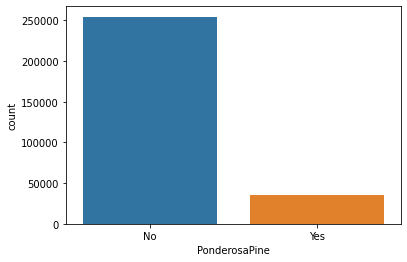

In [ ]:
y =  df['PonderosaPine']
print("타겟데이터의 비율\n",y.value_counts(normalize=True))

%matplotlib inline
sns.countplot(x=y);

In [ ]:
# train, validation, test set으로 먼저 나눠주겠습니다.

from sklearn.model_selection import train_test_split

# 타겟값이 문자형이기 때문에 수치형으로 바꿔주겠습니다.
# df['PonderosaPine'] = df['PonderosaPine'].replace({'No':0, 'Yes':1}).astype('category')

y = df['PonderosaPine']
X = df.drop('PonderosaPine', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,  random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, stratify=y_train)

print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (163311, 12)
X_val shape:  (54438, 12)
X_test shape:  (72583, 12)


In [ ]:
# 기준모델 <<< 중요.. 중요...>>
from sklearn.metrics import accuracy_score

base = y_train.mode()[0]
y_pred_base = len(y_train) * [base]
print("훈련 정확도: ", accuracy_score(y_train, y_pred_base).round(2))

# 검증세트에서도 정확도를 확인해 볼 수 있습니다.
y_pred_base_val = [base] * len(y_val)
print("검증 정확도: ", accuracy_score(y_val, y_pred_base_val).round(2))

print(classification_report(y_val, y_pred_base_val))

훈련 정확도:  0.88
검증 정확도:  0.88


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          No       0.88      1.00      0.93     47734
         Yes       0.00      0.00      0.00      6704

    accuracy                           0.88     54438
   macro avg       0.44      0.50      0.47     54438
weighted avg       0.77      0.88      0.82     54438



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_true0 = y_val.value_counts()[0]
y_true1 = y_val.value_counts()[1]
fn = len(y_pred_base_val) - y_true0
base = pd.DataFrame(index = ['True 0', 'True1'], data = {'Predicted 0':[y_true0, fn], 'Predicted 1':[0,0]})
base

,Predicted 0,Predicted 1
True 0,47734,0
True1,6704,0


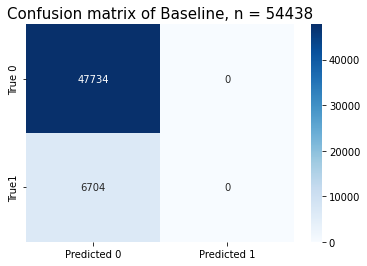

In [ ]:
fig, ax = plt.subplots()
sns.heatmap(base, cmap=plt.cm.Blues, annot=True,fmt="d")
plt.title(f'Confusion matrix of Baseline, n = {len(y_val)}', fontsize=15)
plt.show()

In [ ]:
# 결정트리모델
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

pipe_dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=1, criterion="entropy", max_depth=20, class_weight="balanced",),
)
pipe_dt.fit(X_train, y_train)

print("훈련 정확도: ", pipe_dt.score(X_train, y_train))
print("검증 정확도: ", pipe_dt.score(X_val, y_val))

y_pred_dt = pipe_dt.predict(X_val)
print(classification_report(y_val, y_pred_dt))

훈련 정확도:  0.9914580156878594
검증 정확도:  0.9747786472684522
              precision    recall  f1-score   support

          No       0.99      0.98      0.99     47734
         Yes       0.87      0.93      0.90      6704

    accuracy                           0.97     54438
   macro avg       0.93      0.96      0.94     54438
weighted avg       0.98      0.97      0.98     54438



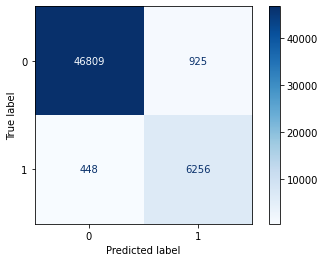

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


def plot_confusion_matrix(model, X_val_encoded, y_val):
    if isinstance(model, DecisionTreeClassifier):
        y_pred = model.predict(X_val_encoded, iteration_range=(0, model.best_iteration))
    else:
        y_pred = model.predict(X_val_encoded)
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap='Blues')
    plt.show()
    
plot_confusion_matrix(pipe_dt, X_val, y_val)

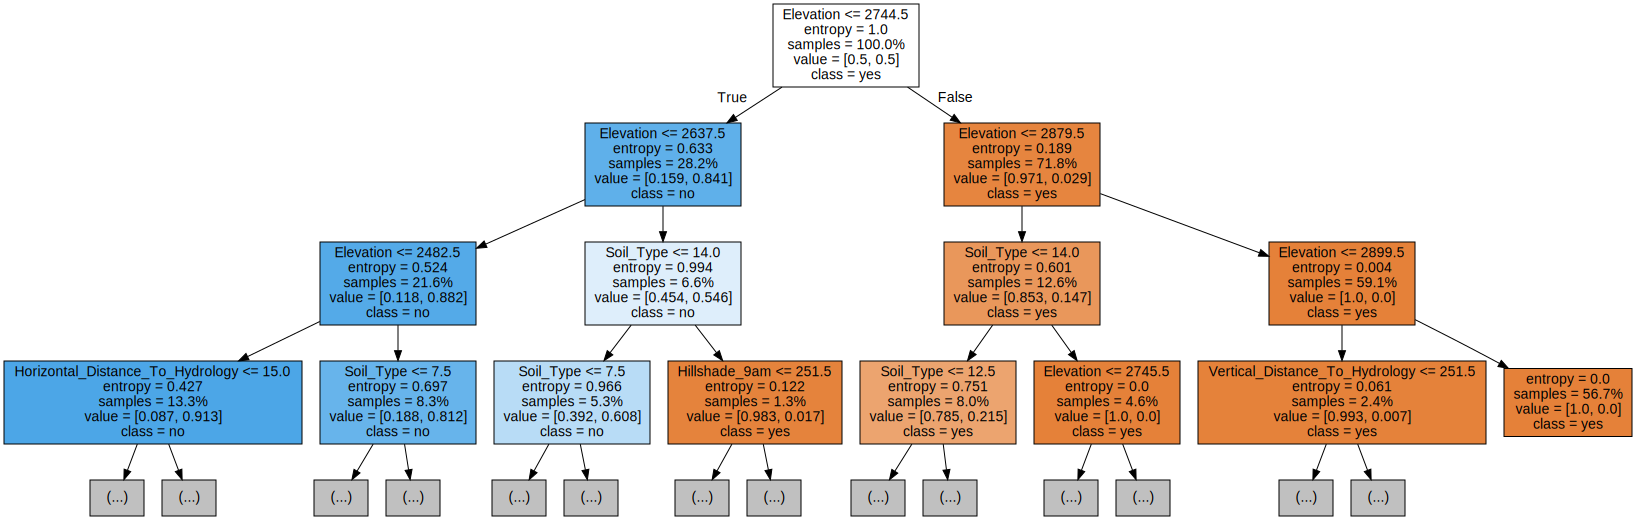

In [ ]:
import graphviz
from sklearn.tree import export_graphviz

# graphviz 설치방법: conda install -c conda-forge python-graphviz

# named_steps 속성을 사용해서 파이프라인의 각 스텝에 접근이 가능합니다.
# named_steps 은 유사 딕셔너리 객체(dictionary-like object)로 파이프라인 내 과정에 접근 가능하도록 합니다.
model_dt = pipe_dt.named_steps['decisiontreeclassifier']
enc = pipe_dt.named_steps['ordinalencoder']
encoded_columns = enc.transform(X_val).columns

dot_data = export_graphviz(model_dt
                          , max_depth=3
                          , feature_names=encoded_columns
                          , class_names=['yes', 'no']
                          , filled=True
                          , proportion=True)


display(graphviz.Source(dot_data))

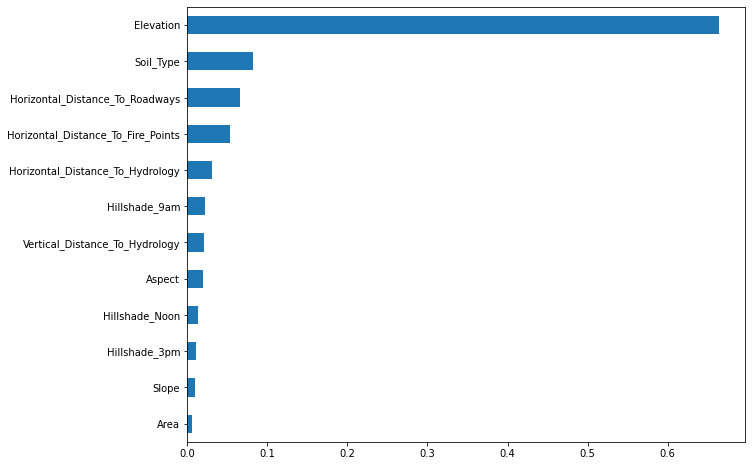

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

model_dt = pipe_dt.named_steps['decisiontreeclassifier']
importances = pd.Series(model_dt.feature_importances_, X_train.columns)
plt.figure(figsize=(10, 8))
importances.sort_values().plot.barh();

In [ ]:
# 랜덤포레스트 모델
from sklearn.ensemble import RandomForestClassifier

pipe_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(
        max_depth = 20,
        random_state=42, 
        oob_score=True, 
        n_jobs=-1,
        class_weight="balanced",
        ),
)

pipe_rf.fit(X_train, y_train)
print("훈련 정확도: ", pipe_rf.score(X_train, y_train))
print("검증 정확도: ", pipe_rf.score(X_val, y_val))

훈련 정확도:  0.9950646312863187
검증 정확도:  0.9808956978581138


In [ ]:
# out-of-bag sample을 이용하여 oob_score를 구할 수 있습니다.
pipe_rf.named_steps["randomforestclassifier"].oob_score_

0.9812994838069695

In [ ]:
y_pred_rf = pipe_rf.predict(X_val)
print(classification_report(y_val, y_pred_rf))

              precision    recall  f1-score   support

          No       0.99      0.98      0.99     47734
         Yes       0.90      0.96      0.93      6704

    accuracy                           0.98     54438
   macro avg       0.94      0.97      0.96     54438
weighted avg       0.98      0.98      0.98     54438



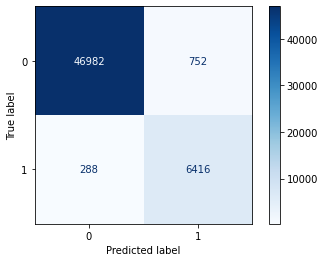

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def plot_confusion_matrix(model, X_val_encoded, y_val):
    if isinstance(model, RandomForestClassifier):
        y_pred = model.predict(X_val_encoded, iteration_range=(0, model.best_iteration))
    else:
        y_pred = model.predict(X_val_encoded)
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap='Blues')
    plt.show()
    
plot_confusion_matrix(pipe_rf, X_val, y_val)

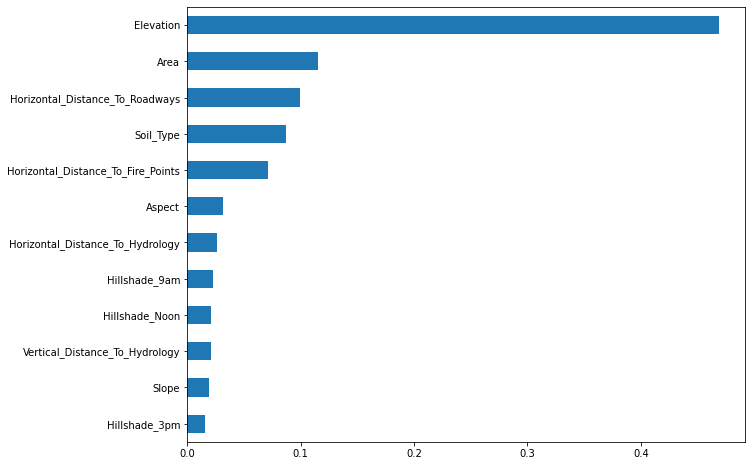

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

model_rf = pipe_rf.named_steps["randomforestclassifier"]
importances = pd.Series(model_rf.feature_importances_, X_train.columns)
plt.figure(figsize=(10, 8))
importances.sort_values().plot.barh();

In [ ]:
# XG부스트 모델
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline


pipe_gb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",  # error = 1 - accuracy 지표를 사용해 평가합니다.
        random_state=42,
        n_jobs=-1,
        max_depth=20,
        learning_rate=0.1,
        scale_pos_weight = 7,
    ),
)
print(pipe_gb)

pipe_gb.fit(X_train, y_train)
print("학습 정확도", pipe_gb.score(X_train, y_train))
print("검증 정확도", pipe_gb.score(X_val, y_val))

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('xgbclassifier',
                 XGBClassifier(eval_metric='error', max_depth=20, n_jobs=-1,
                               random_state=42, scale_pos_weight=7))])
학습 정확도 0.9999877534275095
검증 정확도 0.988519049193578


In [ ]:
y_pred_gb = pipe_gb.predict(X_val)
print(classification_report(y_val, y_pred_gb))

              precision    recall  f1-score   support

          No       1.00      0.99      0.99     47734
         Yes       0.94      0.97      0.95      6704

    accuracy                           0.99     54438
   macro avg       0.97      0.98      0.97     54438
weighted avg       0.99      0.99      0.99     54438



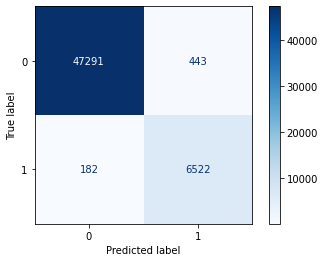

In [ ]:
def plot_confusion_matrix(model, X_val_encoded, y_val):
    if isinstance(model, XGBClassifier):
        y_pred = model.predict(X_val_encoded, iteration_range=(0, model.best_iteration))
    else:
        y_pred = model.predict(X_val_encoded)
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap='Blues')
    plt.show()
    
plot_confusion_matrix(pipe_gb, X_val, y_val)

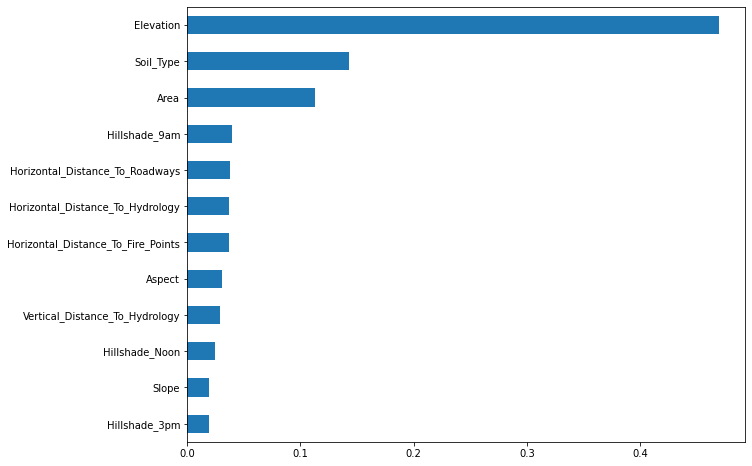

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

model_gb = pipe_gb.named_steps["xgbclassifier"]
importances = pd.Series(model_gb.feature_importances_, X_train.columns)
plt.figure(figsize=(10, 8))
importances.sort_values().plot.barh();